# Exploratory Data Analysis (EDA) - World Happiness Report

## Proje Amacı
Bu çalışma, Dünya Mutluluk Raporu verilerini kullanarak farklı ülkelerin mutluluk düzeylerini etkileyen sosyo-ekonomik faktörleri (GSYİH, sosyal destek, yaşam beklentisi vb.) analiz etmek için geliştirilmiştir.

## Veri Seti Hakkında
Kullanılan veri seti, Gallup Dünya Anketi sonuçlarına dayanmaktadır ve ülkelerin 0-10 arası mutluluk skorlarını içermektedir.

## Kullanılan Araçlar
* **Veri İşleme:** Pandas, NumPy
* **Görselleştirme:** Seaborn, Matplotlib



## 1. Veri Edinme ve Yükleme


In [1]:
import requests
import pandas as pd
import time

# Defining constants and variables

our_url = "https://live.euroleague.net/api/Points"
season = "E2025"
num_of_games = 35

all_games = [] # Our dataframe

print("Fetching data for the first {} games of the {} season.".format(num_of_games,season))

# Data fetching loop

for game_code in range(1,num_of_games + 1):
    
    # It will create a link like : https://live.euroleague.net/api/Points?gamecode=30&seasoncode=E2025

    parameters = {

        'gamecode' : game_code,
        'seasoncode' : season

    }

    # Error handling

    try:
        result = requests.get(our_url, params=parameters, timeout=15)

        result.raise_for_status() # To catch a possible error like 404

        game_data = result.json() # To fetch jason datas from this url


        # Checking whether the incoming data contains rows and whether this rows list is empty
        if game_data and 'Rows' in game_data and game_data['Rows']:

            first_df = pd.DataFrame(game_data['Rows']) # Writing the rows into a Pandas table

            # Adding extra columns to table
            first_df['GAME_CODE'] = game_code
            first_df['SEASON_CODE'] = season 

            all_games.append(first_df) # Adding the resulting small table to the list

        else:
            print("No data available for game number {}".format(game_code)) 
            # If the game data is empty, this alert will appear

    except ValueError:
        print("No valid json data found for game number {}".format(game_code))

    time.sleep(0.25) # Adding a delay between calls


# pd.concat combines the dataframes in the list to create a single dataframe
# ignore_index=True, to arrange the row numbers of the table
all_games_df = pd.concat(all_games, ignore_index=True)

all_games_df['TEAM'] = all_games_df['TEAM'].str.strip().str.upper() # To normalize 'TEAM'

#To show size of DataFrame
print("Size of DataFrame: {}".format(all_games_df.shape))

all_games_df.head().style.hide() # Prints the table without index numbers



Fetching data for the first 35 games of the E2025 season.
Size of DataFrame: (5602, 20)


NUM_ANOT,TEAM,ID_PLAYER,PLAYER,ID_ACTION,ACTION,POINTS,COORD_X,COORD_Y,ZONE,FASTBREAK,SECOND_CHANCE,POINTS_OFF_TURNOVER,MINUTE,CONSOLE,POINTS_A,POINTS_B,UTC,GAME_CODE,SEASON_CODE
4,IST,P014102,"JONES, KAI",2FGM,Two Pointer,2,-12,-6,A,0,0,0,1,09:39,2,0,20250930174549,1,E2025
8,IST,P007200,"LARKIN, SHANE",3FGA,Missed Three Pointer,0,414,602,I,0,0,0,1,09:11,2,0,20250930174617,1,E2025
11,IST,P012710,"OSMANI, ERCAN",2FGM,Two Pointer,2,-307,0,D,0,1,1,2,08:57,4,0,20250930174631,1,E2025
12,TEL,P011219,"SORKIN, ROMAN",2FGM,Two Pointer,2,-81,125,B,0,0,0,2,08:42,4,2,20250930174647,1,E2025
16,TEL,P011219,"SORKIN, ROMAN",FTM,Free Throw In,1,-1,-1,,0,0,0,2,08:42,4,3,20250930174714,1,E2025


## 2. Veri Ön İşleme ve Temizleme (Handling Missing Values)

In [11]:
import pandas as pd
import numpy as np

all_games_df['ACTION'] = all_games_df['ACTION'].str.upper()

points_scored_per_game = all_games_df.groupby(['GAME_CODE', 'TEAM'])['POINTS'].sum()

three_points = all_games_df[all_games_df['ACTION'] == 'THREE POINTER']
points_three = three_points.groupby(['GAME_CODE', 'TEAM'])['POINTS'].sum()

two_points = all_games_df[all_games_df['ACTION'] == 'TWO POINTER']
points_two = two_points.groupby(['GAME_CODE', 'TEAM'])['POINTS'].sum()

all_games_df['FASTBREAK'] = pd.to_numeric(all_games_df['FASTBREAK'], errors='coerce').fillna(0)
fast_break = all_games_df[all_games_df['FASTBREAK'] == 1]
points_fast_break = fast_break.groupby(['GAME_CODE', 'TEAM'])['POINTS'].sum()

stats_df = pd.concat([points_scored_per_game, points_three, points_two, points_fast_break], axis=1)

stats_df.columns = ['points_scored', 'points_3pt', 'points_2pt', 'points_fb']

stats_df = stats_df.fillna(0)

game_total_points = stats_df.groupby('GAME_CODE')['points_scored'].sum().to_frame(name='total_game_points')

stats_df = stats_df.join(game_total_points, on='GAME_CODE')

stats_df['points_conceded'] = stats_df['total_game_points'] - stats_df['points_scored']

team_average = stats_df.groupby('TEAM').mean()

team_average = team_average.drop(columns=['total_game_points'])

metric_columns = [
    'points_scored', 
    'points_conceded', 
    'points_3pt', 
    'points_2pt', 
    'points_fb'
]
team_average = team_average[metric_columns]

league_avg = team_average.mean()
league_avg.name = "League Avg" 

best_team_stats = pd.Series(name="Best Team", dtype=float)
best_team_names = pd.Series(name="Best Team Code", dtype=str)

metric_names = [
    "Points scored per game",
    "Points conceded per game",
    "Points from 3-pointers",
    "Points from 2-pointers",
    "Fast-break points"
]

team_average.columns = metric_names
league_avg.index = metric_names

best_team_stats[metric_names[0]] = team_average[metric_names[0]].max()
best_team_names[metric_names[0]] = team_average[metric_names[0]].idxmax()

best_team_stats[metric_names[1]] = team_average[metric_names[1]].min()
best_team_names[metric_names[1]] = team_average[metric_names[1]].idxmin()

best_team_stats[metric_names[2]] = team_average[metric_names[2]].max()
best_team_names[metric_names[2]] = team_average[metric_names[2]].idxmax()

best_team_stats[metric_names[3]] = team_average[metric_names[3]].max()
best_team_names[metric_names[3]] = team_average[metric_names[3]].idxmax()

best_team_stats[metric_names[4]] = team_average[metric_names[4]].max()
best_team_names[metric_names[4]] = team_average[metric_names[4]].idxmax()

ulk_stats = team_average.loc['ULK']
ist_stats = team_average.loc['IST']

comparison_df = pd.DataFrame([ulk_stats, ist_stats, league_avg, best_team_stats])

comparison_df.index = ['ULK', 'IST', 'League Avg', 'Best Team']

comparison_df = comparison_df.T

print(comparison_df)

                            ULK    IST  League Avg  Best Team
Points scored per game    81.75  83.75   86.129167  97.500000
Points conceded per game  85.00  84.00   86.075000  74.333333
Points from 3-pointers    26.25  28.50   27.725000  37.000000
Points from 2-pointers    38.50  38.50   41.950000  53.333333
Fast-break points         13.00   4.25    9.029167  22.333333


## 3. Keşifsel Veri Analizi ve Görselleştirme

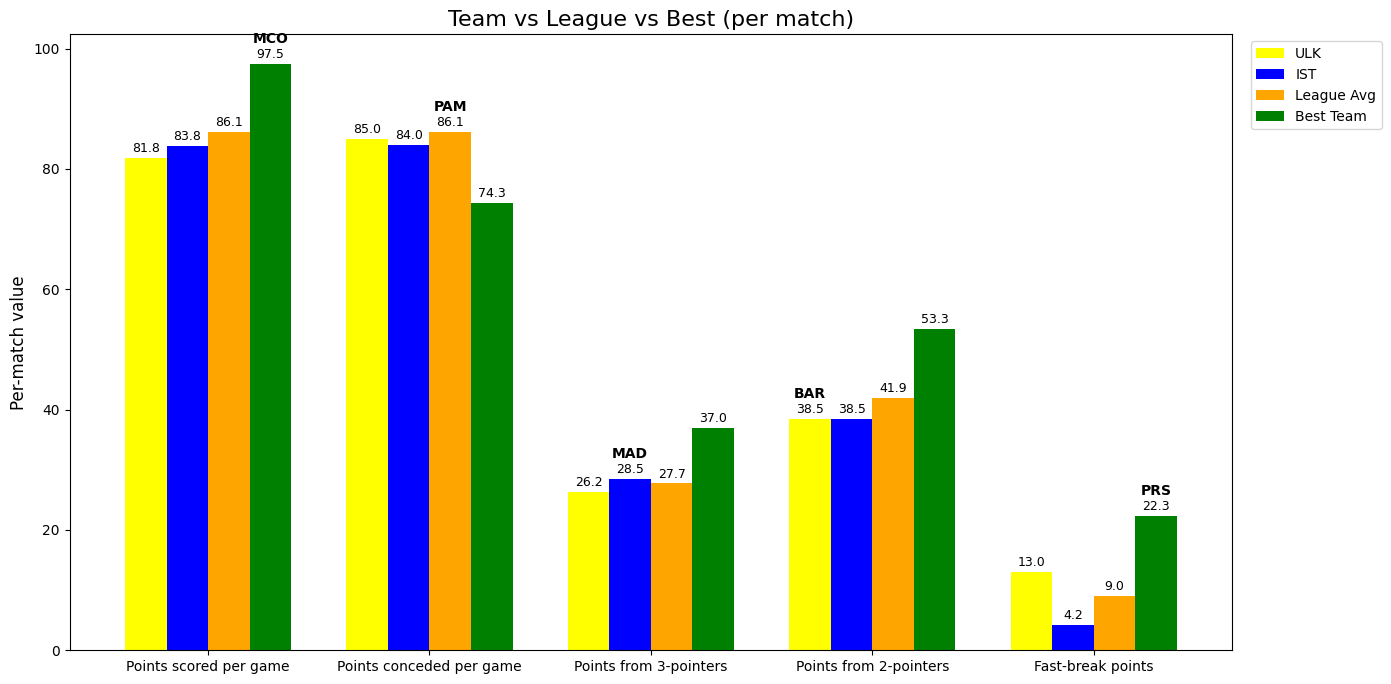

In [12]:
import matplotlib.pyplot as plt
import numpy as np


#Define the colors for our teams
colors = ['yellow', 'blue', 'orange', 'green']
#Get the metric names from the DataFrame
metric_names = comparison_df.index
#Get the team codes for the 'Best Team' bars
best_names_list = best_team_names.values

#Plot the comparison_df as a bar chart
ax = comparison_df.plot(
    kind='bar', 
    figsize=(15, 8), 
    color=colors,     
    width=0.75        
)

#Set main title
ax.set_title("Team vs League vs Best (per match)", fontsize=16)

#Set y-axis label
ax.set_ylabel("Per-match value", fontsize=12)

#Set the metric names on the x-axis
ax.set_xticklabels(metric_names, rotation=0, ha='center', fontsize=10) 

#Adjust legend position
ax.legend(title=None, bbox_to_anchor=(1.01, 1), loc='upper left')

#Loop over each bar patch
for i, bar in enumerate(ax.patches):
    
    height = bar.get_height()
    
    
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0.5, 
        f"{height:.1f}", 
        ha='center', 
        va='bottom',
        fontsize=9
    )
    
    #Check if this bar is the 4th one in its group (which is 'Best Team')
    if (i + 1) % 4 == 0:
        #Find which metric this bar belongs to 0-4
        metric_index = i // 4
        team_name = best_names_list[metric_index]
        
        #Add the best team's name above the value
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 3.0,
            team_name, 
            ha='center', 
            va='bottom',
            fontsize=10,
            fontweight='bold',
            color="#000000"
        )


## 4. Değişkenler Arası İlişki Analizi (Correlation)

In [13]:
import pandas as pd
import numpy as np

all_games_df['ACTION'] = all_games_df['ACTION'].str.upper()

#Filter for made 3 points
df_3pt = all_games_df[all_games_df['ACTION'] == 'THREE POINTER']

#Calculate total 3 point points per player
total_3pt_points = df_3pt.groupby(['PLAYER', 'TEAM'])['POINTS'].sum().reset_index(name='Total 3PT Points')

#Calculate total games played by each player
games_played = all_games_df.groupby(['PLAYER', 'TEAM'])['GAME_CODE'].nunique().reset_index(name='Games Played')

#Merge the two dataframes
player_stats = pd.merge(total_3pt_points, games_played, on=['PLAYER', 'TEAM'])

#Calculate 3-point points per game
player_stats['3PT_PPG'] = player_stats['Total 3PT Points'] / player_stats['Games Played']

#Exclude players currently on 'ULK'
candidates = player_stats[player_stats['TEAM'] != 'ULK']

#Keep players with 3PT_PPG >= 6.0
candidates = candidates[candidates['3PT_PPG'] >= 6.0]

top_5_candidates = candidates.sort_values(by='3PT_PPG', ascending=False).head(5)

#Rename columns
report_df = top_5_candidates[['PLAYER', 'TEAM', '3PT_PPG']].rename(columns={
    'PLAYER': 'Player Name',
    'TEAM': 'Team',
    '3PT_PPG': '3PT Points per Game'
})

print(report_df.to_string(index=False, float_format='{:.1f}'.format))

             Player Name Team  3PT Points per Game
             HIFI, NADIR  PRS                 13.0
           OBST, ANDREAS  MUN                 11.2
        SELJAAS, ZACHARY  ASV                 11.0
LUWAWU-CABARROT, TIMOTHE  BAS                 10.0
          BADIO, BRANCOU  PAM                  9.0
